<a href="https://colab.research.google.com/github/CarlosMendez1997Sei/WETSAT_v2/blob/main/2_Modelling_WETSAT_Google_Colab/Wetsat_Geoprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

	Google Colaboratory
	PostgreSQL
	GitHub	     
	Wetlands flooding extent and trends using SATellite data and Machine Learning WETSAT
	Code Developed by
	Carlos Mendez
	Sebastian Palomino
	Camilo Sanabria                     

# Install packages and libraries used in WETSAT

In [1]:
###################################### Artificial Intelligence Frameworks #####################################################
# Geospatial Artificial Intelligence (GeoAI)
%pip install geoai-py
# scikit-learn Framework
!pip install scikit-learn
# Tensorflow Framework
!pip install tensorflow
# Keras Framework
!pip install Keras
# PyTorch Framework
!pip torch torchvision
###################################### Data, Geoprocessing and Graphics libraries #####################################################
!pip install rasterio
!pip install matplotlib
!pip install numpy
!pip install contextily

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 269.6/269.6 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.5/122.5 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 603.9/603.9 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 65.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 882.2/882.2 kB 50.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 55.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 71.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.2/62.2 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 605.3/605.3 kB 39.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.2/17.2 MB 96.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8

# Import libraries and packages

In [38]:
## AI packages
import geoai
import tensorflow
import keras
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVC

## Geoprocessing packages
import rasterio
from rasterio.features import rasterize
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import os
import contextily as ctx
from shapely.geometry import box
import seaborn as sns

# Clone Repository from WETSAT [GitHub](https://github.com/sei-latam/WETSAT_v2)

In [3]:
!git clone https://github.com/sei-latam/WETSAT_v2.git

Cloning into 'WETSAT_v2'...
remote: Enumerating objects: 638, done.
remote: Counting objects: 100% (69/69), done.
remote: Compressing objects: 100% (59/59), done.
remote: Total 638 (delta 29), reused 21 (delta 7), pack-reused 569 (from 3)
Receiving objects: 100% (638/638), 1.42 GiB | 28.14 MiB/s, done.
Resolving deltas: 100% (84/84), done.
Updating files: 100% (247/247), done.


# Import Sentinel-1 Raster Images (VH-VV polarization)

In [4]:
vh_path = "/content/WETSAT_v2/0_Original_Files/aoi1/aoi1/gamma_dB/VH_gamma_dB/"
vv_path = "/content/WETSAT_v2/0_Original_Files/aoi1/aoi1/gamma_dB/VV_gamma_dB/"

# Visualize images from gamma_dB_vh
'''
gamma_dB_vh_tif = [os.path.join(vh_path, f) for f in os.listdir(vh_path) if f.endswith('.tif')]
for gamma_dB_vh_files in gamma_dB_vh_tif:
    with rasterio.open(gamma_dB_vh_files) as src:
        raster_gamma_dB_vh = src.read(1)
        plt.figure(figsize=(8, 6))
        plt.imshow(raster_gamma_dB_vh, cmap='gray')
        plt.title(f"File: {os.path.basename(gamma_dB_vh_files)}")
        plt.axis('off')
        plt.show()
'''
# Visualize images from gamma_dB_vv
'''
gamma_dB_vv_tif = [os.path.join(vv_path, f) for f in os.listdir(vv_path) if f.endswith('.tif')]
# Visualize images from gamma_dB_vh
for gamma_dB_vv_files in gamma_dB_vv_tif:
    with rasterio.open(gamma_dB_vv_files) as src:
        raster_gamma_dB_vv = src.read(1)
        plt.figure(figsize=(8, 6))
        plt.imshow(raster_gamma_dB_vv, cmap='gray')
        plt.title(f"File: {os.path.basename(gamma_dB_vv_files)}")
        plt.axis('off')
        plt.show()
'''

'\ngamma_dB_vv_tif = [os.path.join(vv_path, f) for f in os.listdir(vv_path) if f.endswith(\'.tif\')]\n# Visualize images from gamma_dB_vh\nfor gamma_dB_vv_files in gamma_dB_vv_tif:\n    with rasterio.open(gamma_dB_vv_files) as src:\n        raster_gamma_dB_vv = src.read(1)\n        plt.figure(figsize=(8, 6))\n        plt.imshow(raster_gamma_dB_vv, cmap=\'gray\')\n        plt.title(f"File: {os.path.basename(gamma_dB_vv_files)}")\n        plt.axis(\'off\')\n        plt.show()\n'

In [5]:
# Create a function to load images in a folder
def load_images(folder_path): # Create a request 'folder path' as a directory of data
    images = [] # Create a temporal empty array of images
    for file in sorted(os.listdir(folder_path)): # Call the folfer 'path'
        if file.endswith(".tif"): # Search images ending in .tif
            with rasterio.open(os.path.join(folder_path, file)) as src: # Open the images located in folder path
                images.append(src.read(1))
    return np.array(images) # Return array of images

# Call function and load images
vh_images = load_images(vh_path)
vv_images = load_images(vv_path)

print(f"System recognized {vh_images.shape[0]} images VH polarization with size {vh_images.shape[1:]} each one.")
print(f"System recognized {vv_images.shape[0]} images VV polarization with size {vv_images.shape[1:]} each one.")
assert vh_images.shape == vv_images.shape, "The dimensions and size of VH-VV polarizations are equal"

# Combine the VH-VV polarization with the same size and dimensions
master_data = np.stack([vh_images, vv_images], axis=-1)  # (n_images)

print(f"System combine the VH-VV polarization wit the size {master_data.shape}")

System recognized 29 images VH polarization with size (1121, 967) each one.
System recognized 29 images VV polarization with size (1121, 967) each one.
System combine the VH-VV polarization wit the size (29, 1121, 967, 2)


# Import points (.shp) with labels and marks

In [6]:
# Open shapefile folder
shapefile_path = "/content/WETSAT_v2/0_Original_Files/aoi1/aoi1/points_AOI1_Mask/points_AOI1.shp"

# Import geopandas and read .shp
gdf = gpd.read_file(shapefile_path)
print(f"The attributes of the .shp are:")
print(gdf)

# Get coordinates of .shp
x_coords = gdf.geometry.x
y_coords = gdf.geometry.y

coords = [(geom.centroid.x, geom.centroid.y) for geom in gdf.geometry]
print(f"The coordinates of the .shp are:")
print(coords)

# Get values of the column "gridcode"
labels = gdf["gridcode"].values

# Print values
print(f"The marks and labels found in .shp are:")
print(labels)

The attributes of the .shp are:
  Station  gridcode                        geometry
0   BCA10        26  POINT (497798.554 2843968.889)
1   BCA20        22  POINT (506542.122 2843182.064)
2    BCA9        26  POINT (508801.018 2851138.964)
3   NP205        22  POINT (515267.347 2841220.576)
4     P34        22  POINT (505933.853 2832231.413)
5     TMC        24   POINT (512822.472 2832943.69)
6  MO-214        22    POINT (497463.68 2832744.37)
The coordinates of the .shp are:
[(497798.55399999954, 2843968.8892), (506542.12179999985, 2843182.0636), (508801.01829999965, 2851138.9639999997), (515267.3468000004, 2841220.5759999994), (505933.8534000004, 2832231.4131000005), (512822.4720999999, 2832943.6898), (497463.6799999997, 2832744.370100001)]
The marks and labels found in .shp are:
[26 22 26 22 22 24 22]


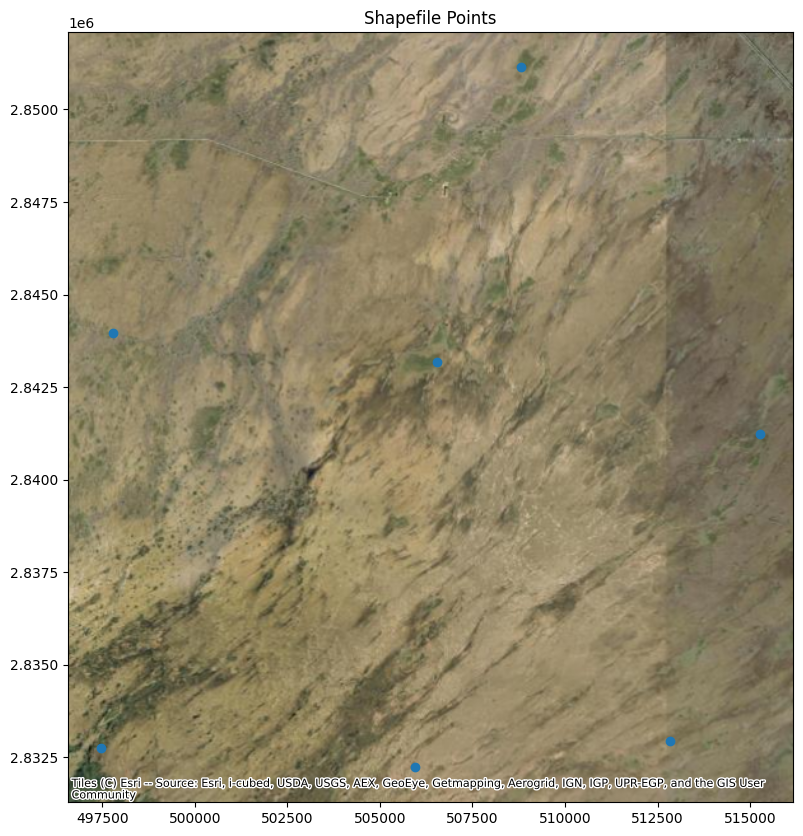

In [15]:
#providers = ctx.providers
#providers

# Plot the .shp
ax = gdf.plot(figsize=(10, 10))
ctx.add_basemap(ax, crs=gdf.crs.to_string(), source=ctx.providers.Esri.WorldImagery)
plt.title('Shapefile Points')
plt.show()

# Create marks/labels and rasterize (convert vector to raster)

In [16]:
# Verify and compare if the .shp have the same .src with vh_path/vv_path
with rasterio.open(os.path.join(vh_path, os.listdir(vh_path)[0])) as src:
    transform = src.transform
    raster_crs = src.crs

print("The Coordinate Reference System (CRS) is :", raster_crs)

gdf = gdf.to_crs(raster_crs)

# Create list with geometries and labels
shapes = [(geom, label) for geom, label in zip(gdf.geometry, gdf["gridcode"])]

# Rasterize the labels
raster_labels = rasterize(
    shapes,
    out_shape=(master_data.shape[1], master_data.shape[2]),  # dimensions
    transform=src.transform,
    fill=0,
    dtype="int32"
)

# Print the rasterization
print("Rasterization process complete with the size:", raster_labels.shape)

print("Bounds image:", src.bounds)
print("Bounds shapefile:", gdf.total_bounds)

raster_bounds = box(*src.bounds)
gdf_filtered = gdf[gdf.geometry.within(raster_bounds)]
print(f"Points inside raster: {len(gdf_filtered)} of {len(gdf)}")

The Coordinate Reference System (CRS) is : EPSG:32617
Rasterization process complete with the size: (1121, 967)
Bounds image: BoundingBox(left=496760.0, bottom=2830500.0, right=516100.0, top=2852920.0)
Bounds shapefile: [ 497463.68   2832231.4131  515267.3468 2851138.964 ]
Points inside raster: 7 of 7


# Create Random Forest and SVM Models

## Prepare training data

In [17]:
# Create x and y train data
X_train = []
y_train = []

# Call function to iterate or looping in each image from master_data dataset
for i in range(master_data.shape[0]): #Calculate the size of master_data
    img = master_data[i]  # Receive height and weight
    img_flat = img.reshape(-1, 2) # Transform the image into an array, when -1 meaning automatic fields and 2 set number of rows
    labels_flat = raster_labels.flatten()
    mask = labels_flat > 0 #Validate only labels > 0

    #Filter or mask data in x/y training data
    X_train.append(img_flat[mask])
    y_train.append(labels_flat[mask])

# Concatenar todos los datos
X_train = np.concatenate(X_train, axis=0)
y_train = np.concatenate(y_train, axis=0)

print(f"Total samples: {X_train.shape[0]}")

Total samples: 203


## Random Forest (RF)

In [45]:
# Define the hyperparameters and grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Initialize the RF model
rf = RandomForestClassifier(random_state=42)
rf.fit(X_tr, y_tr)
print("Accuracy Random Forest Model:", rf.score(X_te, y_te))

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=rf,
                           param_grid=param_grid,
                           cv=3,  # 3-fold cross-validation
                           verbose=2,
                           n_jobs=-1)  # Use all available cores

# Fit to training data
grid_search.fit(X_tr, y_tr)

# Best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)


Accuracy Random Forest Model: 0.7868852459016393
Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best Parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Best Cross-Validation Score: 0.6903073286052009


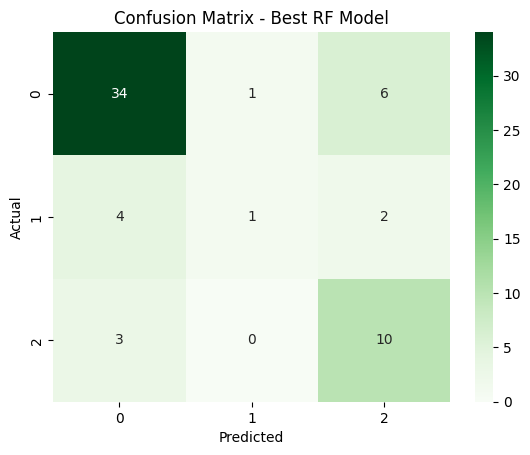

              precision    recall  f1-score   support

          22       0.83      0.83      0.83        41
          24       0.50      0.14      0.22         7
          26       0.56      0.77      0.65        13

    accuracy                           0.74        61
   macro avg       0.63      0.58      0.57        61
weighted avg       0.73      0.74      0.72        61



In [46]:
y_pred_best = best_rf.predict(X_te)

# Confusion Matrix
cm_best = confusion_matrix(y_te, y_pred_best)
sns.heatmap(cm_best, annot=True, fmt='d', cmap='Greens')
plt.title("Confusion Matrix - Best RF Model")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Classification Report
print(classification_report(y_te, y_pred_best))

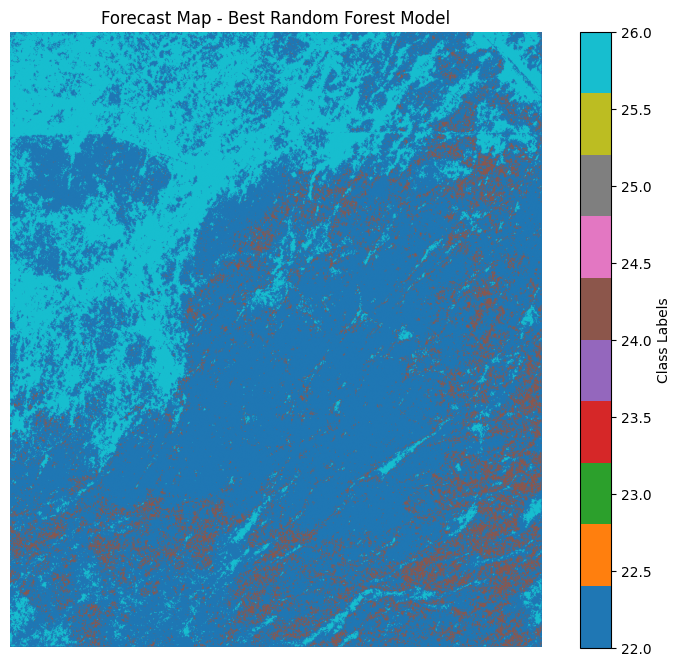

In [47]:
img = master_data[0] # Select an Image S1 (combined VH/VV)

height, width = img.shape[:2] # select first image

# Create a new organization of data to forecast pixels
img_flat = img.reshape(-1, 2)

# Predict with best model
predicted_labels_best = best_rf.predict(img_flat)
predicted_raster_best = predicted_labels_best.reshape(height, width)

# Visualize results
plt.figure(figsize=(10, 8))
plt.imshow(predicted_raster_best, cmap='tab10')
plt.title("Forecast Map - Best Random Forest Model")
plt.colorbar(label='Class Labels')
plt.axis('off')
plt.show()

## Support Vector Machine (SVM)

In [48]:
# Define hyperparameters and grid
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto'],
    'degree': [2, 3, 4]  # Only used for 'poly' kernel
}

# Initialize SVM model
svm = SVC()
svm.fit(X_tr, y_tr)
print("Accuracy Support Vector Machine (SVM) Model:", svm.score(X_tr, y_tr))

# Set up GridSearchCV
grid_search_svm = GridSearchCV(estimator=svm,
                                param_grid=param_grid,
                                cv=3,
                                verbose=2,
                                n_jobs=-1)

# Fit to training data
grid_search_svm.fit(X_tr, y_tr)

# Best parameters and score
print("Best Parameters (SVM):", grid_search_svm.best_params_)
print("Best Cross-Validation Score (SVM):", grid_search_svm.best_score_)

best_svm = grid_search_svm.best_estimator_
y_pred_svm = best_svm.predict(X_te)

Accuracy Support Vector Machine (SVM) Model: 0.7323943661971831
Fitting 3 folds for each of 54 candidates, totalling 162 fits
Best Parameters (SVM): {'C': 10, 'degree': 3, 'gamma': 'auto', 'kernel': 'poly'}
Best Cross-Validation Score (SVM): 0.7324172576832151


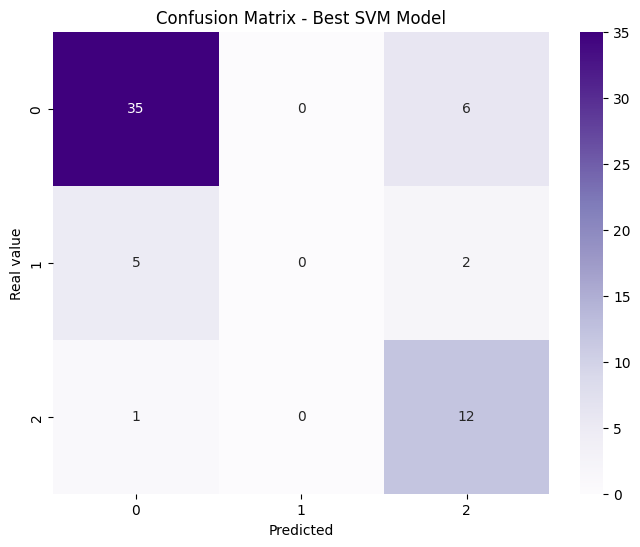

Classification Report - Best SVM Model
              precision    recall  f1-score   support

          22       0.85      0.85      0.85        41
          24       0.00      0.00      0.00         7
          26       0.60      0.92      0.73        13

    accuracy                           0.77        61
   macro avg       0.48      0.59      0.53        61
weighted avg       0.70      0.77      0.73        61



In [50]:
# Calculate confusion matrix

# Visualize data
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_te, y_pred_svm), annot=True, fmt='d', cmap='Purples')
plt.title("Confusion Matrix - Best SVM Model")
plt.xlabel("Predicted")
plt.ylabel("Real value")
plt.show()

# Print results
print("Classification Report - Best SVM Model")
print(classification_report(y_te, y_pred_svm))

In [51]:
img = master_data[0] # Select an Image S1 (combined VH/VV)

height, width = img.shape[:2] # select first image

# Create a new organization of data to forecast pixels
img_flat = img.reshape(-1, 2)

# Delete NaN or null values if there are
mask_valid = ~np.isnan(img_flat).any(axis=1)
img_flat_clean = img_flat[mask_valid]

# Forecasting labels only for valid pixels
predicted_labels_svm = svm.predict(img_flat_clean)

# Create a new empty raster and fill with valid pixels
predicted_raster_svm = np.zeros(img_flat.shape[0], dtype=predicted_labels_svm.dtype)
predicted_raster_svm[mask_valid] = predicted_labels_svm
predicted_raster_svm = predicted_raster_svm.reshape(height, width)

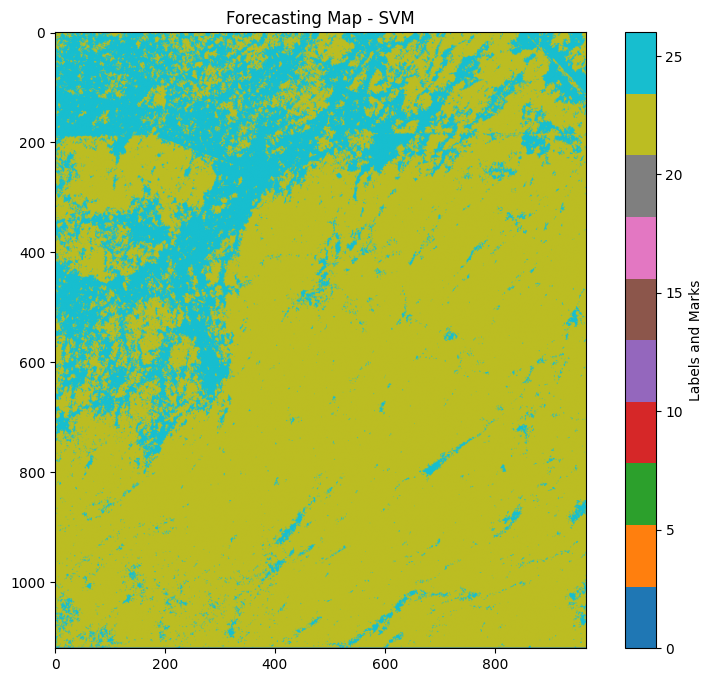

In [52]:
plt.figure(figsize=(10, 8))
plt.imshow(predicted_raster_svm, cmap='tab10')
plt.title("Forecasting Map - SVM")
plt.axis('on')
plt.colorbar(label='Labels and Marks')
plt.show()